# Accurate methods for anchor points identification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import contamination

from cln.AP_identification import AnchorPointsIdentification
from third_party import arc

In [32]:
## Sampling parameters
n_train = 1000
n_cal = 1000
K = 4
num_var = 20
n_informative = 2
n_redundant = num_var - n_informative
n_clusters_per_class = 1
#n_informative = np.maximum(1, int(num_var*0.5))
#n_redundant = 2
#n_clusters_per_class = 2
class_sep = 1
random_state = 2026
epsilon0 = 0.01
epsilon = 0.1

In [33]:
T = contamination.construct_T_matrix_simple(K, epsilon)

In [34]:
X, Y = make_classification(n_samples=n_train+n_cal,
                           n_classes=K,
                           n_features=num_var,
                           n_informative=n_informative,
                           n_redundant=n_redundant,
                           n_clusters_per_class=n_clusters_per_class,
                           flip_y = epsilon0,
                           class_sep=class_sep, random_state=random_state)
Y = Y.astype(np.int32)
contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+2)
Yt = contamination_process.sample_labels(Y)

# split tmp into train vs calibration
X_train, X_cal, Y_train, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, stratify=Y, random_state=random_state + 1)

In [35]:
# Anchor points identified with the benchmark method
black_box = arc.black_boxes.RFC(n_estimators=100, max_features="sqrt")
black_box_pt = copy.deepcopy(black_box)
black_box_pt.fit(X_train, Yt_train)

p_hat = black_box_pt.predict_proba(X_cal)

gamma_opt = 0.03

m_benchmark = AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=gamma_opt)
X_anchor_benchmark, Y_anchor_benchmark, anchor_idx_benchmark = m_benchmark.get_anchor_dataset(X_cal)
accuracy_benchmark = np.sum(Y_anchor_benchmark==Y_cal[anchor_idx_benchmark])/len(anchor_idx_benchmark)

In [36]:
print(len(anchor_idx_benchmark)) # 4 * 0.03*1000 = 120 (OK mi torna)
print(accuracy_benchmark)

120
0.9916666666666667


In [37]:
# Filter anchor points by taking only the deeper ones
m_filtered = AnchorPointsIdentification(X_cal, Yt_cal, K, black_box_pt, gamma=gamma_opt, ap_filter=True)
X_anchor_filtered, Y_anchor_filtered, anchor_idx_filtered = m_filtered.get_anchor_dataset(X_cal)

accuracy_filtered = np.sum(Y_anchor_filtered==Y_cal[anchor_idx_filtered])/len(anchor_idx_filtered)

In [38]:
print(len(anchor_idx_filtered)) # 4 * top 20 in ogni classe = 80 (OK)
print(accuracy_filtered)

80
1.0


PLOT RESULTS

In [39]:
# PCA on the full calibration set
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X_cal)
Z_anchor_benchmark = Z[anchor_idx_benchmark]
Z_anchor_filtered = Z[anchor_idx_filtered]

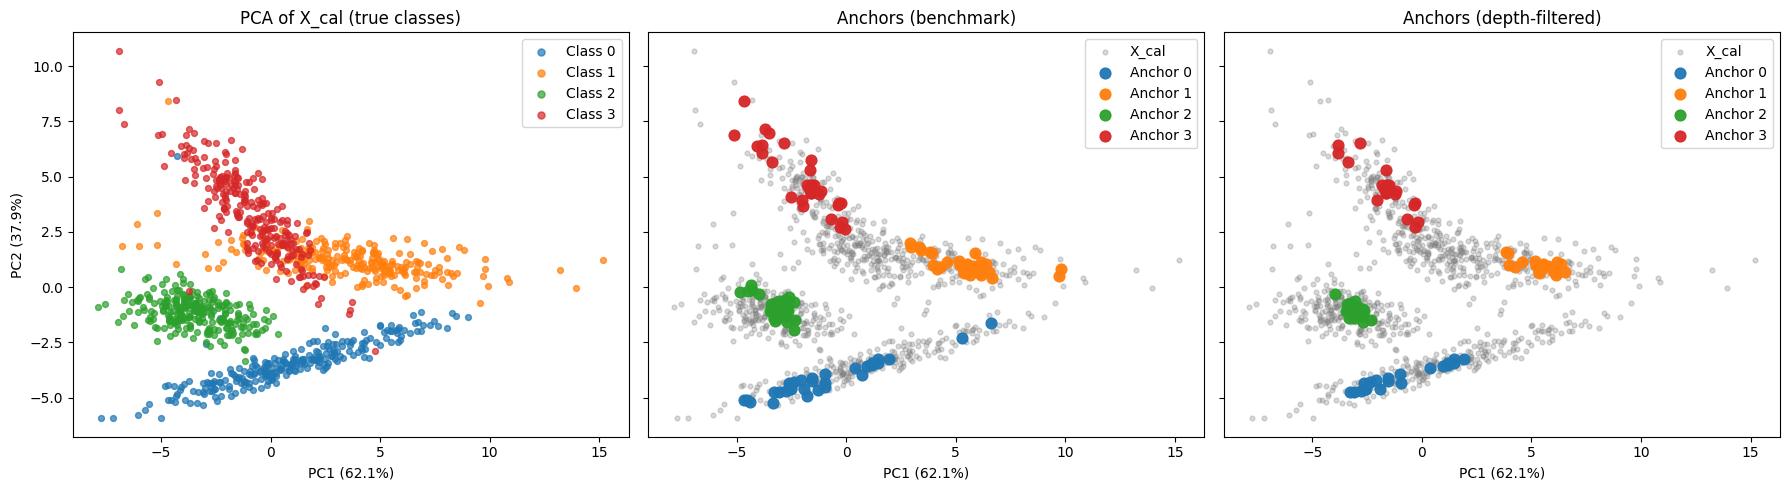

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

classes = np.unique(Y_cal)


ax = axes[0]
for c in classes:
    mask_c = (Y_cal == c)
    ax.scatter(Z[mask_c, 0], Z[mask_c, 1],
               s=18, alpha=0.7, label=f"Class {c}")

ax.set_title("PCA of X_cal (true classes)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(markerscale=1.2)


ax = axes[1]
ax.scatter(Z[:, 0], Z[:, 1], c="grey", s=12, alpha=0.30, label="X_cal")

for c in classes:
    mask_c = (Y_anchor_benchmark == c)
    ax.scatter(Z_anchor_benchmark[mask_c, 0], Z_anchor_benchmark[mask_c, 1],
               s=60, alpha=0.95, label=f"Anchor {c}")

ax.set_title("Anchors (benchmark)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.legend()


ax = axes[2]
ax.scatter(Z[:, 0], Z[:, 1], c="grey", s=12, alpha=0.30, label="X_cal")

for c in classes:
    mask_c = (Y_anchor_filtered == c)
    ax.scatter(Z_anchor_filtered[mask_c, 0], Z_anchor_filtered[mask_c, 1],
               s=60, alpha=0.95, label=f"Anchor {c}")

ax.set_title("Anchors (depth-filtered)")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.legend()


plt.tight_layout()
plt.show()


In [41]:
# Print performances
print("Performance of the Benchmark method")
sys.stdout.flush()
print("\nNumerosity of the anchor points set: {:d}".format(len(anchor_idx_benchmark)))
sys.stdout.flush()
print("\nAccuracy of the anchor points set: {:f}".format(accuracy_benchmark))
sys.stdout.flush()

print("\nPerformance after filtering with Mahalanobis distance")
sys.stdout.flush()
print("\nNumerosity of the anchor points set: {:d}".format(len(anchor_idx_filtered)))
sys.stdout.flush()
print("\nAccuracy of the anchor points set: {:f}".format(accuracy_filtered))
sys.stdout.flush()

Performance of the Benchmark method

Numerosity of the anchor points set: 120

Accuracy of the anchor points set: 0.991667

Performance after filtering with Mahalanobis distance

Numerosity of the anchor points set: 80

Accuracy of the anchor points set: 1.000000
